# Team Quantum Dudes 

* Simon Jaxy
* Joshua Schwarz
* Peter Naeve
* Davide Valenti
* Junbo Huang
* Stefan Balle


# Visualization of Entangled Qubits as a Chain 

Given a statevector containing information about the states of qubits represented in theta and phi angles, this code generates a visual representation in the form of a qubit-chain. 
The code is ready to go as-is, using a customized statevector containing 4 qubits to demonstrate the visualization. 
Statevectors generated bei QuantumCircuits can be used (an example of a simple entanglement circuit can be activated below by unquoting the marked passage). 

To generate the visualization, the theta and phi angles are translated into cartesian coordinates to use for plotting with matplotlib. Qubits following the first one are placed at the tip of the last qubit's vector, and the orientation of the qubit is changed according to the direction of the previous qubit. That way, information can be retrieved, starting at the first qubit, getting information of the next by reversing the angle-shifts according to the previous qubit. 


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pprint import pprint
from scipy import linalg as la
import math
from math import pi

from qiskit import execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute, register, get_backend
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.qi.qi import state_fidelity
from qiskit import Aer

from qiskit.tools.visualization import plot_histogram, plot_state

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

Statevector: [(1+0j), 0j, (0.5+0.5j), 1j, (-0.2+1j), (0.5+0.5j), (-0.8-0.2j), (-0.2-0.8j)]
Number of qubits: 4

Plotting qubit 0
Theta Current: 90.0
Theta Prev: 0.0
Phi Current 0.0
Phi Prev: 0.0
Theta_Phi_To_X_Y_Z for qubit 0 : [1.000000e+00 0.000000e+00 6.123234e-17]

Plotting qubit 1
Theta Current: 45.0
Theta Prev: 90.0
Phi Current 90.0
Phi Prev: 0.0
Theta_Phi_To_X_Y_Z for qubit 1 : [ 1.          0.70710678 -0.70710678]

Plotting qubit 2
Theta Current: -11.30993247402022
Theta Prev: 135.0
Phi Current 45.0
Phi Prev: 90.0
Theta_Phi_To_X_Y_Z for qubit 2 : [ 0.41165159  1.29545519 -1.26180698]

Plotting qubit 3
Theta Current: 255.9637565320735
Theta Prev: 123.69006752597979
Phi Current -104.0362434679265
Phi Prev: 135.0
Theta_Phi_To_X_Y_Z for qubit 3 : [ 0.70005768  1.46849884 -0.32006507]


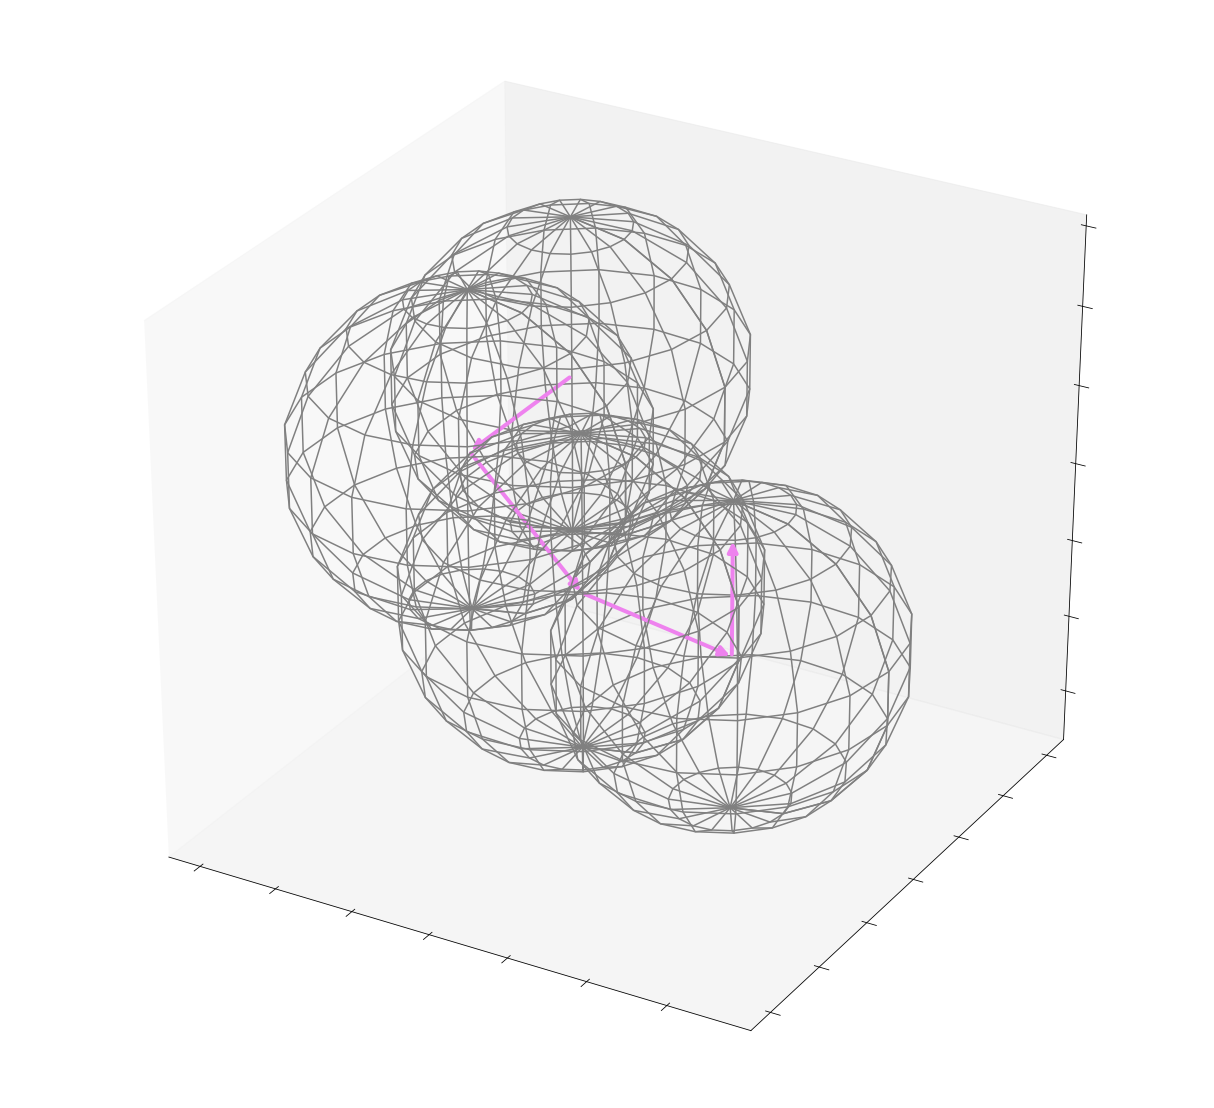

In [2]:
##
## To run the visualization, use visualize_entanglement_chain(statevector),
## passing an artificially crafted statevector or one generated by a QuantumCircuit. 
##


# Init Plot 
fig = plt.figure(figsize=(30,20))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
ax.grid(False)
ax.axis('on')
ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')


# Draw Sphere
def draw_sphere(x_origin,y_origin,z_origin):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x + y_origin , y - x_origin, z + z_origin, color="grey")


# Draw Arrows 
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        
        xs = [-x for x in xs]
        self._verts3d = ys, xs, zs # Swap directions to account for qiskit nomenclatur

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
        
# Project theta and phi angles onto unit-circle; create cartesian coordinates 
#    
#     Z    ^
#         |
#         | __->  Y
#        /
#    x  \/ 
# 
# Theta rotating around  Y-axis, starting at z-axis, first traversing positive x 
# Phi rotating around Z-axis, starting at x-axis, first traversing positive y 
#
# Compare for format https://www.st-andrews.ac.uk/physics/quvis/simulations_html5/sims/blochsphere/blochsphere.html
# 
def theta_phi_to_x_y_z_on_unit_circle(centerxyz,theta,phi):
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    return x + centerxyz[0], y + centerxyz[1], z + centerxyz[2]
    

# Plot entangled qubit visualization  
def visualize_entanglement_chain(statevector):
    
    # Check input 
    if statevector is None or len(statevector) % 2 != 0: 
        print("Statevector is malformed!")
        
    # Init values 
    print('Statevector:', statevector)
    no_qubits = len(statevector) // 2  
    print("Number of qubits:",no_qubits)
    current_qubit = 0 
    theta_current = 0
    phi_current = 0
    theta_prev = 0
    phi_prev = 0
    center_new = [0,0,0]
    xyz = np.zeros((no_qubits,3))
    
    
    # Go through all qubits 
    while current_qubit < no_qubits:
        
        print("\nPlotting qubit",current_qubit)
        
        # Get current cartesian representation for theta and phi 
        # For calculation of current xyz values, take into account theta and phi of previous qubits 
        theta_current = np.pi/2 - np.angle(statevector[current_qubit*2]) # 90 degrees - angle of complex number due to different axes
        print('Theta Current:', theta_current * 360 / 2 / np.pi)
        print('Theta Prev:', theta_prev * 360 / 2 / np.pi)
        phi_current = np.angle(statevector[current_qubit*2 + 1])
        print('Phi Current', phi_current * 360 / 2 / np.pi)
        print('Phi Prev:', phi_prev * 360 / 2 / np.pi)
        xyz[current_qubit] = theta_phi_to_x_y_z_on_unit_circle(center_new,theta_current + theta_prev,phi_current + phi_prev)
        print("Theta_Phi_To_X_Y_Z for qubit", current_qubit, ":", xyz[current_qubit])
        
        # Draw sphere & arrow 
        # For arrow, use center and newly calculated xyz values 
        draw_sphere(center_new[0],center_new[1],center_new[2])
        arrow_x_y_z = [[center_new[0], xyz[current_qubit][0]], [center_new[1], xyz[current_qubit][1]], [center_new[2], xyz[current_qubit][2]]]
        arrow = Arrow3D(arrow_x_y_z[0],arrow_x_y_z[1],arrow_x_y_z[2], mutation_scale=20, lw=4, arrowstyle="-|>", color="violet") # Directions from ... to ... for x, y, z 
        ax.add_artist(arrow)
        
        # Save angles to use for next qubit and update qubit number
        theta_prev += theta_current
        phi_prev += phi_current
        center_new = xyz[current_qubit]
        current_qubit += 1
        
    # Start visualization     
    plt.show()



    

# The shape 
statevector = [0.70710678+0j, 0+0j, 0+0.70710678j, 0+0j, 0-0.70710678j, 0, 0+0j, 0.70710678+0j, 0+0.70710678j, 0, 0+0.70710678j, 0,0+0.70710678j, 0]

# Other shape 
statevector = [1+0.j, 0.+0.j, 0.5+0.5j, 0.+1.j, -0.2+1j, 0.5+0.5j, -0.8+-0.2j, -0.2+-0.8j]

#
# Uncomment to use QuantumCircuit to generate statevector instead
'''
n = 2  # number of qubits 
q = QuantumRegister(n)
c = ClassicalRegister(n, "c")
qc = QuantumCircuit(q, c)
qc.h(q[0]) # Basic Entanglement Circuit
qc.cx(q[0],q[1])
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
statevector = job.result().get_statevector(qc)
circuit_drawer(qc)
'''
# 
#


visualize_entanglement_chain(statevector)